# *Salix* and *Populus* sequence capture: Species trees

Brian J. Sanderson

Last updated: 6 May 2020

Required Python libraries: ete3, IPython.core.display

Other required programs: [ASTRAL-III](https://github.com/smirarab/ASTRAL/), [DendroPy](https://dendropy.org/), [phyparts](https://bitbucket.org/blackrim/phyparts), [phypartspiecharts.py](https://github.com/mossmatters/phyloscripts/tree/master/phypartspiecharts), [minority_report.py](https://github.com/mossmatters/phyloscripts/tree/master/minorityreport)

---

This analysis notebook describes the supertree phylogenetic analysis of a trial set of three *Populus* and three *Salix* species using our targeteds seqeunce capture array, which continues from the results of the notebook title [*Salix* and *Populus* sequence capture: Assembly and Gene Trees](https://github.com/BrianSanderson/phylo-seq-cap/blob/master/notebooks/Phylo_Trial_01_Assembly.ipynb).

## Create species trees with ASTRAL

For the remainder of this analysis I transferred the ```${WORK_DIR}``` from the HPCC to a local server, so there the analyses that follow were all run without submission scripts.

I have adapted much of this from a pipeline Matt Johnson kindly shared with me.

### Prepare gene trees for ASTRAL

1. Collapse gene tree branches if less than 33% gene tree bootstrap support

   ASTRAL weights quartet information evenly, so if there are nodes that have no support they should be collapsed prior to species tree estimation

```bash
parallel --gnu --eta -j 20 sumtrees.py --replace RAxML/bootstrap/RAxML_bootstrap.{} -f 0.33 -F newick --suppress-annotations -o RAxML/collapsed/RAxML_collapsed.{}.tre -i newick -t RAxML/bestTree/RAxML_bestTree.{} :::: genenames.txt
```

2. Reformat sumtrees files

   Sumtrees inserts some characters into the tre files that are non-standard, and need to be removed prior to downstream analysis, do so with the following:

```bash
for i in RAxML/collapsed/*.tre; do sed -i "s/\[&U\] //g;s/'//g;s/ /_/g" "$i"; done
for i in RAxML/collapsed/*.tre; do sed -i "s/'//g" "$i"; done
```

3. Reroot gene trees, delete empty gene trees, using ete3 in Python

   This code will reroot the gene trees, and print out the names of any genes for which there are not valid gene trees

In [1]:
import os
from ete3 import Tree
outgroup_names = ["I_polycarpa_WGS-2"]

filesToReroot = os.listdir("RAxML/collapsed")

for unrooted in filesToReroot:
    unrootedPath = "RAxML/collapsed/" + unrooted
    rootedPath = "RAxML/rerooted/" + unrooted
    t = Tree(unrootedPath.rstrip())
    outgroups_in_tree = list(set(t.get_leaf_names()).intersection(set(outgroup_names)))
    if len(outgroups_in_tree) > 1:
        ancestor = t.get_common_ancestor(outgroups_in_tree)
        if ancestor == t:
            ingroups_in_tree = list(set(t.get_leaf_names()).difference(set(outgroups_in_tree)))
            ancestor = t.get_common_ancestor(ingroups_in_tree)
            t.set_outgroup(ancestor)
            t.write(outfile=rootedPath)
        else:
            t.set_outgroup(ancestor)
            t.write(outfile=rootedPath)
    elif len(outgroups_in_tree) == 1:
        t.set_outgroup(outgroups_in_tree[0])
        t.write(outfile=rootedPath)
    else:
        continue

**note:** the errors above are caused by genes in which the outgroup I_polycarpa isn't present

4. Concatenate re-rooted, collapsed gene trees

```bash   
for i in RAxML/rerooted/*.tre 
    do cat "$i" >> RAxML/genetrees.all.tre
    printf "\n" >> RAxML/genetrees.all.tre
done
```

### Create a species trees with ASTRAL for all genes


1. Species tree

```bash
java -jar astral.5.6.1.jar -i RAxML/genetrees.all.tre -o RAxML/speciestree.all.tre
```

2. Run "multilocus bootstrap" of the species tree with ASTRAL using RAxML boootstrap replicates of each gene tree

```bash
ls RAxML/rerooted/ | sed -e 's/collapsed/bootstrap/g; s/\.tre//g; s/^/RAxML\/bootstrap\//g' > bootstrap_filenames.all.txt

java -jar astral.5.6.1.jar -i RAxML/genetrees.all.tre -o RAxML/speciestree.all.bootstrapValues.tre -b bootstrap_filenames.all.txt -r 100
```

3. Use sumtrees (from [DendroPy](https://dendropy.org/)) to replace the local posterior probabilities on the species trees with the bootstrap probabilities for those nodes

```bash
sumtrees.py --replace RAxML/speciestree.all.bootstrapValues.tre -f 0 -F newick --suppress-annotations -o RAxML/speciestree.all.boot.tre -i newick -t RAxML/speciestree.all.tre
```

4. Remove the extraneous codes that sumtrees adds to our trees

```bash
sed -i "s/\[&U\] //g;s/'//g;s/ /_/g" RAxML/speciestree.all.boot.tre
sed -i "s/'//g" RAxML/speciestree.all.boot.tre
```

5. Reroot the species trees using ete3 in Python

In [2]:
import sys
import os
from ete3 import Tree, TreeStyle

outgroup_names = ["I_polycarpa_WGS-2"]
unrootedPath = "RAxML/speciestree.all.boot.tre"
rootedPath = "RAxML/speciestree.all.boot.rerooted.tre"

t = Tree(unrootedPath.rstrip())
outgroups_in_tree = list(set(t.get_leaf_names()).intersection(set(outgroup_names)))
if len(outgroups_in_tree) > 1:
    ancestor = t.get_common_ancestor(outgroups_in_tree)
    if ancestor == t:
        ingroups_in_tree = list(set(t.get_leaf_names()).difference(set(outgroups_in_tree)))
        ancestor = t.get_common_ancestor(ingroups_in_tree)
        t.set_outgroup(ancestor)
        t.ladderize(direction=1)
        t.write(outfile=rootedPath)
    else:
        t.set_outgroup(ancestor)
        t.ladderize(direction=1)
        t.write(outfile=rootedPath)
elif len(outgroups_in_tree) == 1:
    t.set_outgroup(outgroups_in_tree[0])
    t.ladderize(direction=1)
    t.write(outfile=rootedPath)

*note*: the following cell will crash the Python kernel unless you are running an X-Window server/emulator. On Windows I use [VcXsrv](https://sourceforge.net/projects/vcxsrv/)

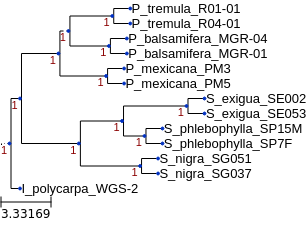

In [3]:
ts = TreeStyle()
ts.show_branch_support = True
ts.show_leaf_name = True
t.render("%%inline", tree_style=ts) 

## Estimate gene tree concordance using phyparts

phyparts will compare the bifurcations of the gene trees and the species trees to summarize how many gene trees agree with the species tree topology.

```bash
java -jar phyparts-0.0.1-SNAPSHOT-jar-with-dependencies.jar -d RAxML/rerooted/ -m RAxML/speciestree.all.boot.rerooted.tre -a 1 -v

mkdir RAxML/phyparts 
mkdir RAxML/phyparts/all
mv out.* RAxML/phyparts/
```

The script ```phypartspiecharts.py```, written by Matt Johnson, plots a tree with pie charts representing gene tree concordance at the nodes. For more detail see [Matt's github page](https://github.com/mossmatters/phyloscripts/tree/master/phypartspiecharts).

**Note**: I modified the script to hard-code a more color-blind-friendly palatte.

```bash
python phypartspiecharts.py RAxML/speciestree.all.boot.rerooted.tre RAxML/phyparts/all/out 1203 --no_ladderize --show_nodes --svg_name RAxML/speciestree.all.boot.pies.svg
```


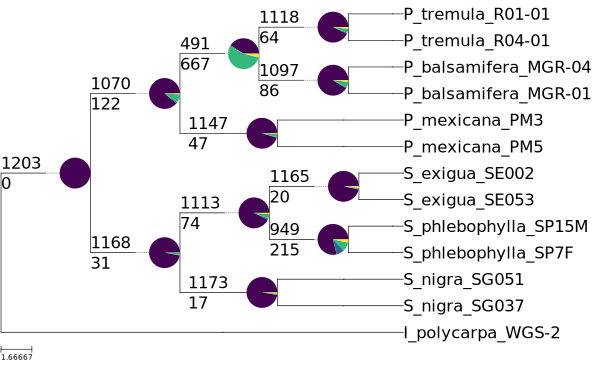

In [4]:
from IPython.core.display import SVG
SVG(filename="RAxML/speciestree.all.boot.pies.svg")

### Create a species trees with ASTRAL for single-copy genes (with no paralog warnings)

Essentially repeating the previous analysis, but using only the subset of the 593 putatively single-copy genes in our target set that did not report paralog warnings in the HybPiper run.

The following just prepares a directory including only these genes, and then prepares the concatenated genetrees file for ASTRAL-III

```bash
while read -r i
    do cp RAxML/rerooted/RAxML_collapsed.${i}.tre RAxML/toAstral-sc/
done < single_copy_genes.tsv

while read -r j
    do rm RAxML/toAstral-sc/RAxML_collapsed.${j}.tre
done < genesWithParalogs.txt

for i in RAxML/toAstral-sc/*.tre 
    do cat "$i" >> RAxML/genetrees.sc.tre
    printf "\n" >> RAxML/genetrees.sc.tre
done
```

1. Species tree

```bash
java -jar astral.5.6.1.jar -i RAxML/genetrees.sc.tre -o RAxML/speciestree.sc.tre
```

2. Run "multilocus bootstrap" of the species tree with ASTRAL using RAxML boootstrap replicates of each gene tree

```bash
ls RAxML/toAstral-sc/ | sed -e 's/collapsed/bootstrap/g; s/\.tre//g; s/^/RAxML\/bootstrap\//g' > bootstrap_filenames.sc.txt

java -jar astral.5.6.1.jar -i RAxML/genetrees.sc.tre -o RAxML/speciestree.sc.bootstrapValues.tre -b bootstrap_filenames.sc.txt -r 100
```

3. Use sumtrees to replace the local posterior probabilities on the species trees with the bootstrap probabilities for those nodes

```bash
sumtrees.py --replace RAxML/speciestree.sc.bootstrapValues.tre -f 0 -F newick --suppress-annotations -o RAxML/speciestree.sc.boot.tre -i newick -t RAxML/speciestree.sc.tre
```

4. Remove the extraneous codes that sumtrees adds to our trees

```bash
sed -i "s/\[&U\] //g;s/'//g;s/ /_/g" RAxML/speciestree.sc.boot.tre
sed -i "s/'//g" RAxML/speciestree.sc.boot.tre
```

5. Reroot the species trees using ete3 in Python

In [5]:
import sys
import os
from ete3 import Tree, TreeStyle

outgroup_names = ["I_polycarpa_WGS-2"]
unrootedPath = "RAxML/speciestree.sc.boot.tre"
rootedPath = "RAxML/speciestree.sc.boot.rerooted.tre"

t = Tree(unrootedPath.rstrip())
outgroups_in_tree = list(set(t.get_leaf_names()).intersection(set(outgroup_names)))
if len(outgroups_in_tree) > 1:
    ancestor = t.get_common_ancestor(outgroups_in_tree)
    if ancestor == t:
        ingroups_in_tree = list(set(t.get_leaf_names()).difference(set(outgroups_in_tree)))
        ancestor = t.get_common_ancestor(ingroups_in_tree)
        t.set_outgroup(ancestor)
        t.ladderize(direction=1)
        t.write(outfile=rootedPath)
    else:
        t.set_outgroup(ancestor)
        t.ladderize(direction=1)
        t.write(outfile=rootedPath)
elif len(outgroups_in_tree) == 1:
    t.set_outgroup(outgroups_in_tree[0])
    t.ladderize(direction=1)
    t.write(outfile=rootedPath)



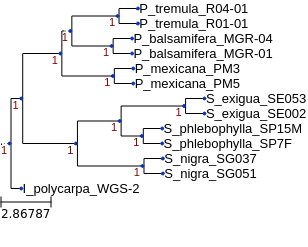

In [6]:
ts = TreeStyle()
ts.show_branch_support = True
ts.show_leaf_name = True
t.ladderize(direction=1)
t.render("%%inline", tree_style=ts) 

## Estimate gene tree concordance using phyparts

```bash
java -jar phyparts-0.0.1-SNAPSHOT-jar-with-dependencies.jar -d RAxML/toAstral-sc/ -m RAxML/speciestree.sc.boot.rerooted.tre -a 1 -v

mv out.* RAxML/phyparts/
```

```bash
python phypartspiecharts.py RAxML/speciestree.sc.boot.rerooted.tre RAxML/phyparts/sc/out 432 --show_nodes --svg_name RAxML/speciestree.sc.boot.pies.svg
```


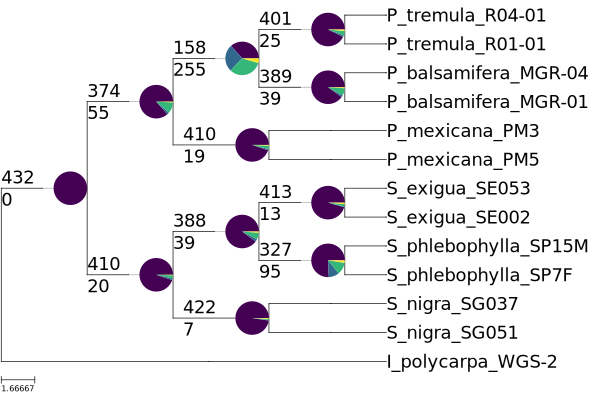

In [7]:
from IPython.core.display import SVG
SVG(filename="RAxML/speciestree.sc.boot.pies.svg")

## Identify domimant alternative topologies

There is a large blue wedge at the node separating *P. tremula* and *P. balsamifera*, and another at the node for *S. phlebophylla*. This wedge represents the number of gene trees that support a single alternative toplogy than the one that is displayed on the tree. The script ```minority_report.py``` written by Matt Johnson can plot these alternative topologies. For more detail see [Matt's github site](https://github.com/mossmatters/phyloscripts/tree/master/minorityreport)

### *Populus* alternative toplogies

Run ```minorityreport.py```:

```bash
python /home/brian/bin/HybPiper/minorityreport.py RAxML/speciestree.sc.boot.rerooted.tre RAxML/phyparts/sc/out 7 20
```

Plot in notebook:

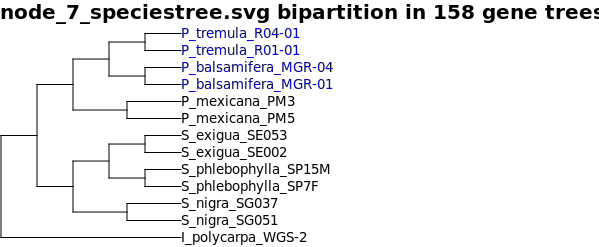

In [8]:
SVG(filename="node_7_speciestree.svg")

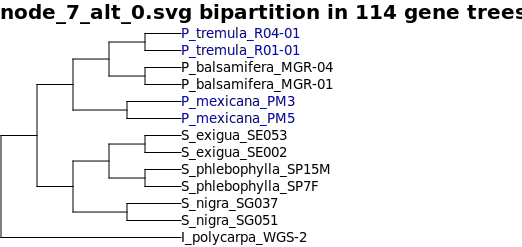

In [9]:
SVG(filename="node_7_alt_0.svg")

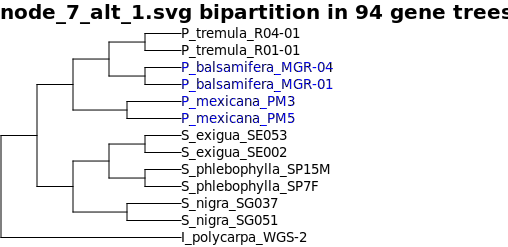

In [10]:
SVG(filename="node_7_alt_1.svg")

### *Salix* alternative topologies



```bash
python minority_report.py RAxML/speciestree.sc.boot.rerooted.tre RAxML/phyparts/sc/out 3 20
```

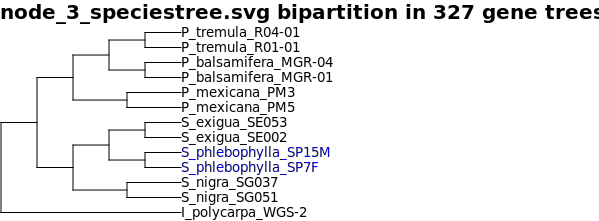

In [11]:
SVG(filename="node_3_speciestree.svg")

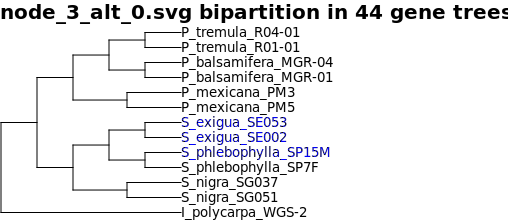

In [12]:
SVG(filename="node_3_alt_0.svg")

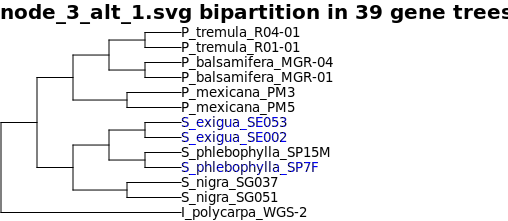

In [13]:
SVG(filename="node_3_alt_1.svg")